In [1]:
import arviz as az
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import theano
from pymc3.distributions import continuous, distribution
from theano import scan, shared
import networkx as nx
import pymc

### Read Data

In [218]:
pickup_data = pd.read_csv('PickUp_Apr_County_Count.csv')
selected_county = pd.read_csv('selected_county.csv')
acs_county = pd.read_csv('ACS_county.csv')
#pickup_data.merge(acs_county, how='inner', on='GISJOIN')

In [219]:
pickup_data.head()

,OID_,GISJOIN,Hour,FREQUENCY
0,0,G0900010,0,8
1,1,G0900010,2,4
2,2,G0900010,3,2
3,3,G0900010,4,2
4,4,G0900010,5,2


In [220]:
df = selected_county.loc[selected_county.index.repeat(24)].reset_index(drop=True)

# Create a new 'hour' column based on the repetition
df['Hour'] = df.groupby('GISJOIN').cumcount()

In [221]:
df = df.merge(pickup_data,how='left', on=['GISJOIN','Hour'])
df['FREQUENCY'].fillna(0, inplace=True)
df = df.drop(['OID__x', 'OID__y'], axis=1)
df = df.merge(acs_county, how='left', on='GISJOIN')

In [222]:
# get base number
df_base = df[df['Hour'].isin([2, 3, 4, 5])]
df_base = df_base.groupby('GISJOIN').agg({'FREQUENCY':'mean'})

In [223]:
df = df.merge(df_base, how='left', on='GISJOIN',suffixes=('', '_base'))
df.loc[df['FREQUENCY_base'] == 0, 'FREQUENCY_base'] = 0.001
df.head()

,NAMELSAD,GISJOIN,Hour,FREQUENCY,STATE,POP,WPLACE,WPOP,HOUSE,FREQUENCY_base
0,Middlesex County,G0900070,0,0.0,Connecticut,163368,87502.0,137404.0,76124,0.001
1,Middlesex County,G0900070,1,0.0,Connecticut,163368,87502.0,137404.0,76124,0.001
2,Middlesex County,G0900070,2,0.0,Connecticut,163368,87502.0,137404.0,76124,0.001
3,Middlesex County,G0900070,3,0.0,Connecticut,163368,87502.0,137404.0,76124,0.001
4,Middlesex County,G0900070,4,0.0,Connecticut,163368,87502.0,137404.0,76124,0.001


In [224]:
pivot_df = df.pivot(index='GISJOIN', columns='Hour', values='FREQUENCY')
pivot_df.reset_index(inplace=True)
pivot_df = pivot_df.merge(df[['GISJOIN','POP','WPOP','HOUSE','FREQUENCY_base']].drop_duplicates(), how='left', on='GISJOIN')
pivot_df.head()

,GISJOIN,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,POP,WPOP,HOUSE,FREQUENCY_base
0,G0900010,8.0,0.0,4.0,2.0,2.0,2.0,5.0,6.0,8.0,...,14.0,16.0,22.0,25.0,23.0,7.0,944348,754186.0,370999,2.500
1,G0900050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,183031,153270.0,88153,0.001
2,G0900070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,163368,137404.0,76124,0.001
3,G0900090,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,859339,705188.0,366266,0.250
4,G3400030,18.0,9.0,5.0,10.0,18.0,25.0,24.0,22.0,29.0,...,34.0,31.0,32.0,37.0,27.0,25.0,929999,755651.0,356654,14.500


In [225]:
#neighborhood info
adj = pd.read_csv('Neighbor_county.csv')
adj = adj.groupby('src_GISJOI')['nbr_GISJOI'].agg(list).reset_index()
new_column_names = {'src_GISJOI': 'GISJOIN', 'nbr_GISJOI': 'ADJ'}
adj.rename(columns=new_column_names, inplace=True)
adj.head()

,GISJOIN,ADJ
0,G0900010,"[G0900050, G0900090, G3600270, G3600790, G3601..."
1,G0900050,"[G0900010, G0900090, G3600270]"
2,G0900070,[G0900090]
3,G0900090,"[G0900010, G0900050, G0900070]"
4,G3400030,"[G3400130, G3400170, G3400310, G3600610, G3600..."


In [226]:
pivot_df = pivot_df.merge(adj,how='left',on='GISJOIN')
pivot_df.head()

,GISJOIN,0,1,2,3,4,5,6,7,8,...,19,20,21,22,23,POP,WPOP,HOUSE,FREQUENCY_base,ADJ
0,G0900010,8.0,0.0,4.0,2.0,2.0,2.0,5.0,6.0,8.0,...,16.0,22.0,25.0,23.0,7.0,944348,754186.0,370999,2.500,"[G0900050, G0900090, G3600270, G3600790, G3601..."
1,G0900050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,183031,153270.0,88153,0.001,"[G0900010, G0900090, G3600270]"
2,G0900070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,163368,137404.0,76124,0.001,[G0900090]
3,G0900090,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,859339,705188.0,366266,0.250,"[G0900010, G0900050, G0900070]"
4,G3400030,18.0,9.0,5.0,10.0,18.0,25.0,24.0,22.0,29.0,...,31.0,32.0,37.0,27.0,25.0,929999,755651.0,356654,14.500,"[G3400130, G3400170, G3400310, G3600610, G3600..."


In [227]:
# Create a graph from the DataFrame
G = nx.Graph()

for _, row in pivot_df.iterrows():
    src = row['GISJOIN']
    for nbr in row['ADJ']:
        G.add_edge(src, nbr)
        
weight_matrix = nx.adjacency_matrix(G).toarray()
weight_matrix

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Model I: Bayesian Baseline Model

In [228]:
# Format data
X = np.array(df[['POP','WPOP','HOUSE']])
base_n = np.array(df['FREQUENCY_base'])
Y = np.array(df['FREQUENCY'])

In [13]:
# Define the Bayesian model
with pm.Model() as model1:
    # Priors for the linear regression coefficients
    alpha = pm.Normal('alpha', mu=0, sd=100)  #flat distribution
    beta = pm.Normal('beta', mu=0, sd=10, shape=X.shape[1])
    epsilon = pm.Normal('epsilon', mu=0, sd=1, shape=X.shape[0]) 

    # Linear regression model for log(R_it)
    #log_R_it = alpha + pm.math.dot(X, beta) + epsilon
    
    R = pm.Deterministic('R',pm.math.exp(alpha + pm.math.dot(X, beta) + epsilon))
    
    # Exponential transformation to get R_it
    #R_it = pm.math.exp(log_R_it)

    # Likelihood for the count variable Y_it
    Y_obs = pm.Poisson('Y_obs', mu=R * base_n, observed=Y)
    
    start = pm.find_MAP()

    # Sample from the posterior distribution
    trace = pm.sample(5000, start=start, tune=1000, random_seed=42)
    burned_trace = trace[2000:]

/var/folders/_b/2fh86x4j0qj7kqwt0z4153jm0000gn/T/ipykernel_1189/236720686.py:22: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(5000, start=start, tune=1000, random_seed=42)
/Users/yaxuanzhang/anaconda3/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 277 seconds.
The acceptance probability does not match the target. It is 0.9503491598610373, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9225952072145501, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9531620902055802, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rh

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/yaxuanzhang/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

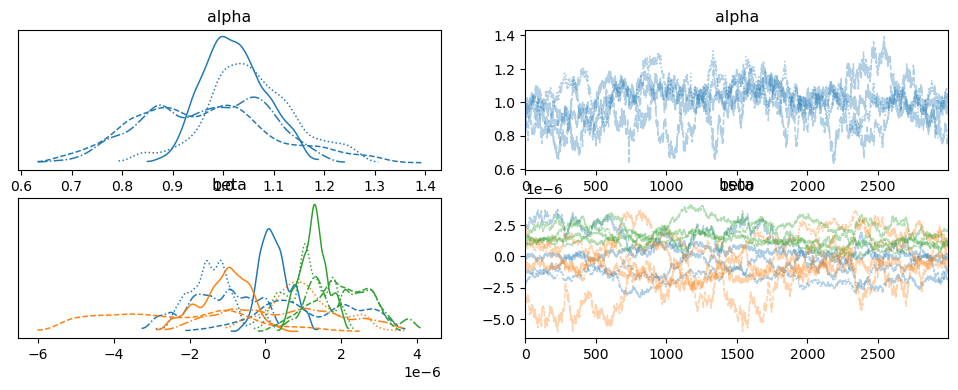

In [14]:
az.plot_trace(burned_trace, var_names=["alpha", "beta"])

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/yaxuanzhang/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>,
       <Axes: title={'center': 'beta\n2'}>], dtype=object)

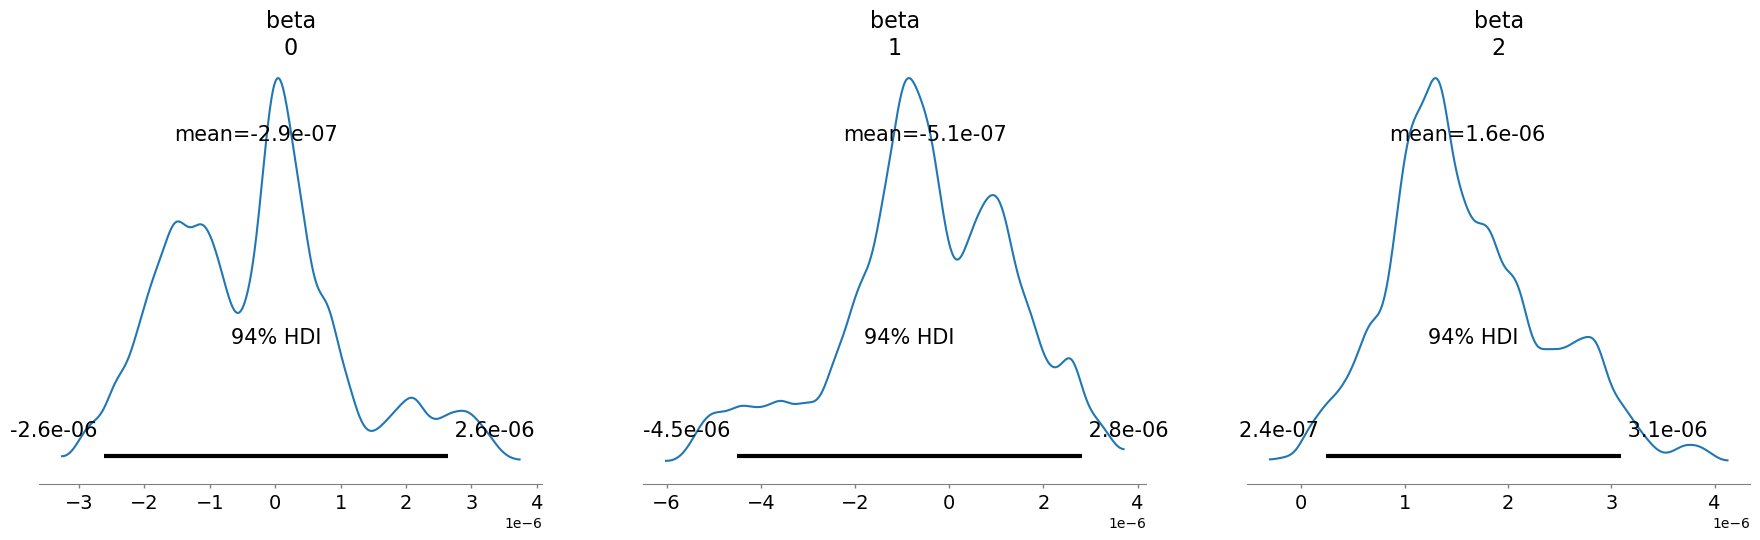

In [15]:
az.plot_posterior(burned_trace, var_names=["beta"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


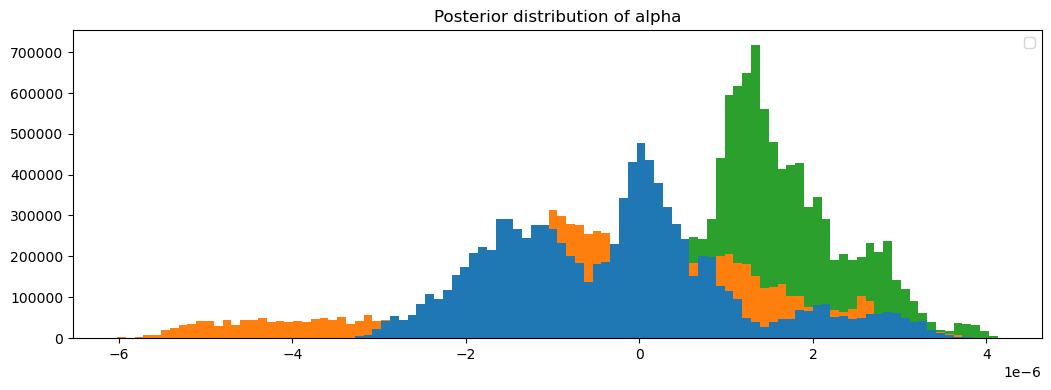

In [16]:
figsize(12.5, 4)
plt.title("Posterior distribution of alpha")
plt.hist(burned_trace["beta"], bins = 100, histtype="stepfilled", density=True)
plt.legend()

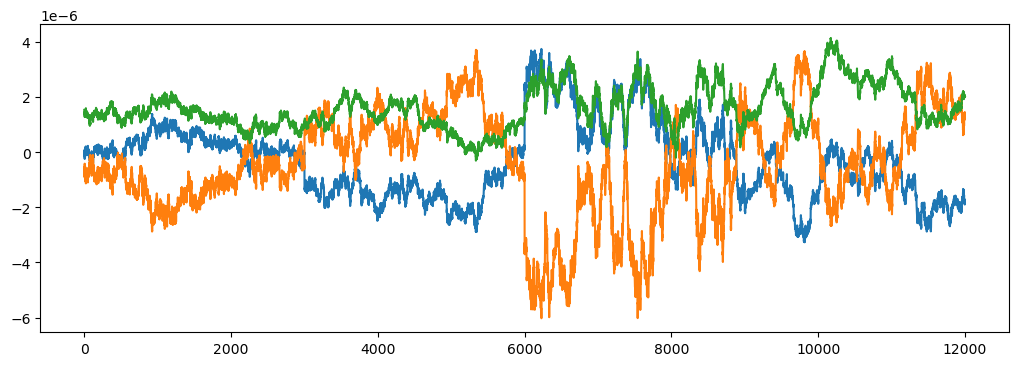

In [17]:
#plt.plot(burned_trace["alpha"])
plt.plot(burned_trace["beta"])
#plt.title("Displaying (extreme) case of dependence between unknowns");

### Model II: Bayesian Spatial Dependency Model

In [18]:
#data
N = pivot_df.shape[0]
T = 24
X = np.array(pivot_df[['POP','WPOP','HOUSE']])
base_n = np.array(pivot_df['FREQUENCY_base'])
Y = np.array(pivot_df.iloc[:,1:25])
wmat = weight_matrix.astype('float')
#amat = weight_matrix.astype("int32")
D = np.diag(wmat.sum(axis=1))

In [19]:
with pm.Model() as model2:
    # Vague prior on intercept
    alpha = pm.Normal('alpha', mu=0, sd=100)  #flat distribution
    # Vague prior on covariate effect
    beta = pm.Normal('beta', mu=0, sd=10, shape=X.shape[1])
    
    epsilon = pm.Normal('epsilon', mu=0, sd=1, shape=(X.shape[0],T)) 
        
    # Spatial clustering prior
    #tau_c = pm.Gamma("tau_c", alpha=1.0, beta=1.0)
    # Regional random effects
    #theta = pm.Normal("theta", mu=0.0, tau=tau_h, shape=N)
    #mu_theta = CAR2("mu_theta", w=wmat, a=amat, tau=tau_c, shape=N)
    # Zero-centre phi
    #theta = pm.Deterministic("theta", mu_theta - tt.mean(mu_theta))
    
    # Priors for spatial random effects
    tau = pm.Gamma("tau", alpha=2.0, beta=2.0)
    theta_alpha = pm.Uniform("theta_alpha", lower=0, upper=1)
    theta = pm.MvNormal("theta", mu=0, tau=tau * (D - theta_alpha * wmat), shape=N)

    # Mean model
    R = pm.Deterministic("R", alpha + pm.math.dot(X, beta)  + theta)
    
    # Define the likelihood with random noise for each hour
    for i in range(T):
        obs = pm.Poisson(f'obs_{i}', mu= base_n * pm.math.exp(R + epsilon[:, i]), observed=Y[:, i])

    #print(mu_theta.tag.test_value)
    # Likelihood
    #Yi = pm.Poisson("Yi", mu= base_n_flat * R , observed=Y_flat)
    #print(R.reshape((X.shape[0],T)).tag.test_value)
    
    start = pm.find_MAP()

    # Sample from the posterior distribution
    #print(model2.test_point)
    
    trace_spatial = pm.sample(5000, tune=1000, start = start, cores=1, target_accept=0.85)
    
    burned_trace_spatial = trace_spatial[2000:]

/var/folders/_b/2fh86x4j0qj7kqwt0z4153jm0000gn/T/ipykernel_1189/1719343227.py:39: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace_spatial = pm.sample(5000, tune=1000, start = start, cores=1, target_accept=0.85)
/Users/yaxuanzhang/anaconda3/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, theta_alpha, tau, epsilon, beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 7143 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 5000 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5809631022818065, but should be close to 0.85. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/yaxuanzhang/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

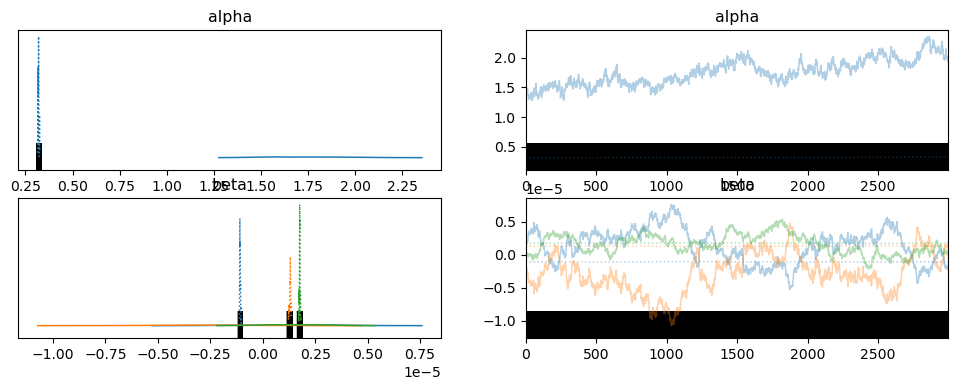

In [20]:
az.plot_trace(burned_trace_spatial, var_names=["alpha", "beta"])

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/yaxuanzhang/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>,
       <Axes: title={'center': 'beta\n2'}>], dtype=object)

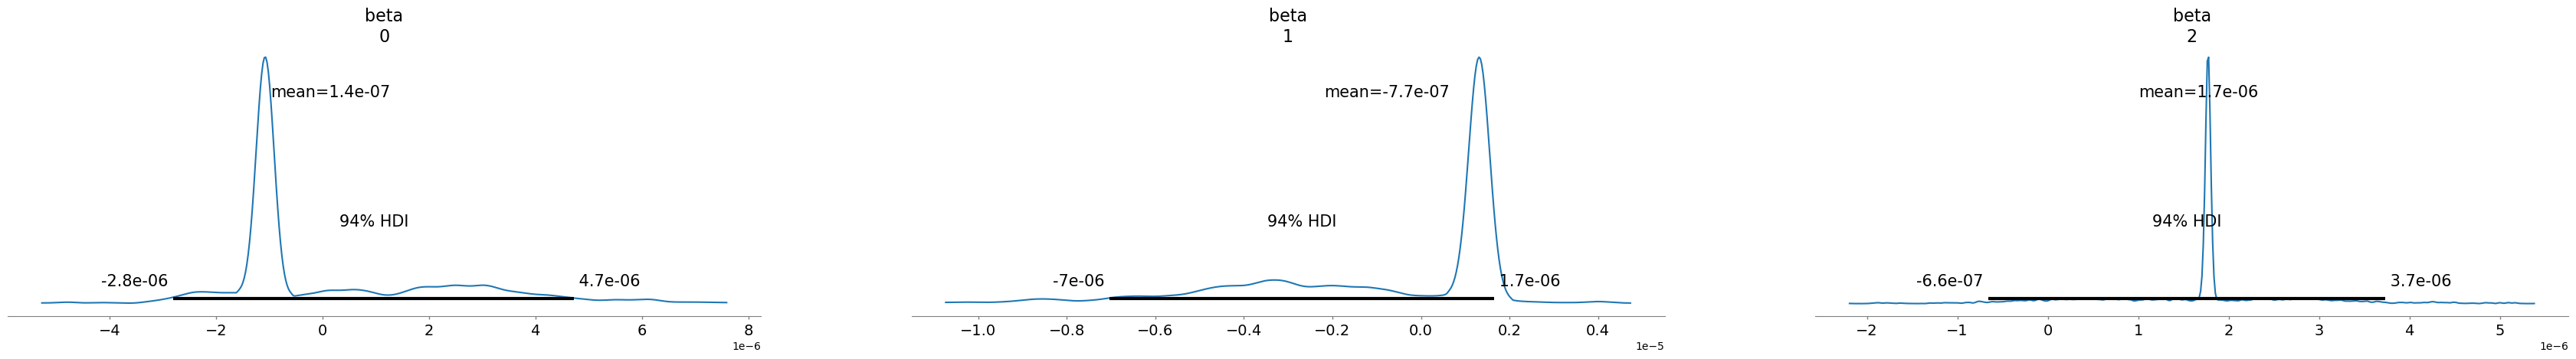

In [21]:
az.plot_posterior(burned_trace_spatial, var_names=["beta"])

Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'theta\n0'}>,
        <Axes: title={'center': 'theta\n1'}>,
        <Axes: title={'center': 'theta\n2'}>,
        <Axes: title={'center': 'theta\n3'}>],
       [<Axes: title={'center': 'theta\n4'}>,
        <Axes: title={'center': 'theta\n5'}>,
        <Axes: title={'center': 'theta\n6'}>,
        <Axes: title={'center': 'theta\n7'}>],
       [<Axes: title={'center': 'theta\n8'}>,
        <Axes: title={'center': 'theta\n9'}>,
        <Axes: title={'center': 'theta\n10'}>,
        <Axes: title={'center': 'theta\n11'}>],
       [<Axes: title={'center': 'theta\n12'}>,
        <Axes: title={'center': 'theta\n13'}>,
        <Axes: title={'center': 'theta\n14'}>,
        <Axes: title={'center': 'theta\n15'}>],
       [<Axes: title={'center': 'theta\n16'}>,
        <Axes: title={'center': 'theta\n17'}>,
        <Axes: title={'center': 'theta\n18'}>,
        <Axes: title={'center': 'theta\n19'}>],
       [<Axes: title={'center': 'theta\n20'}>,
        <Axes: tit

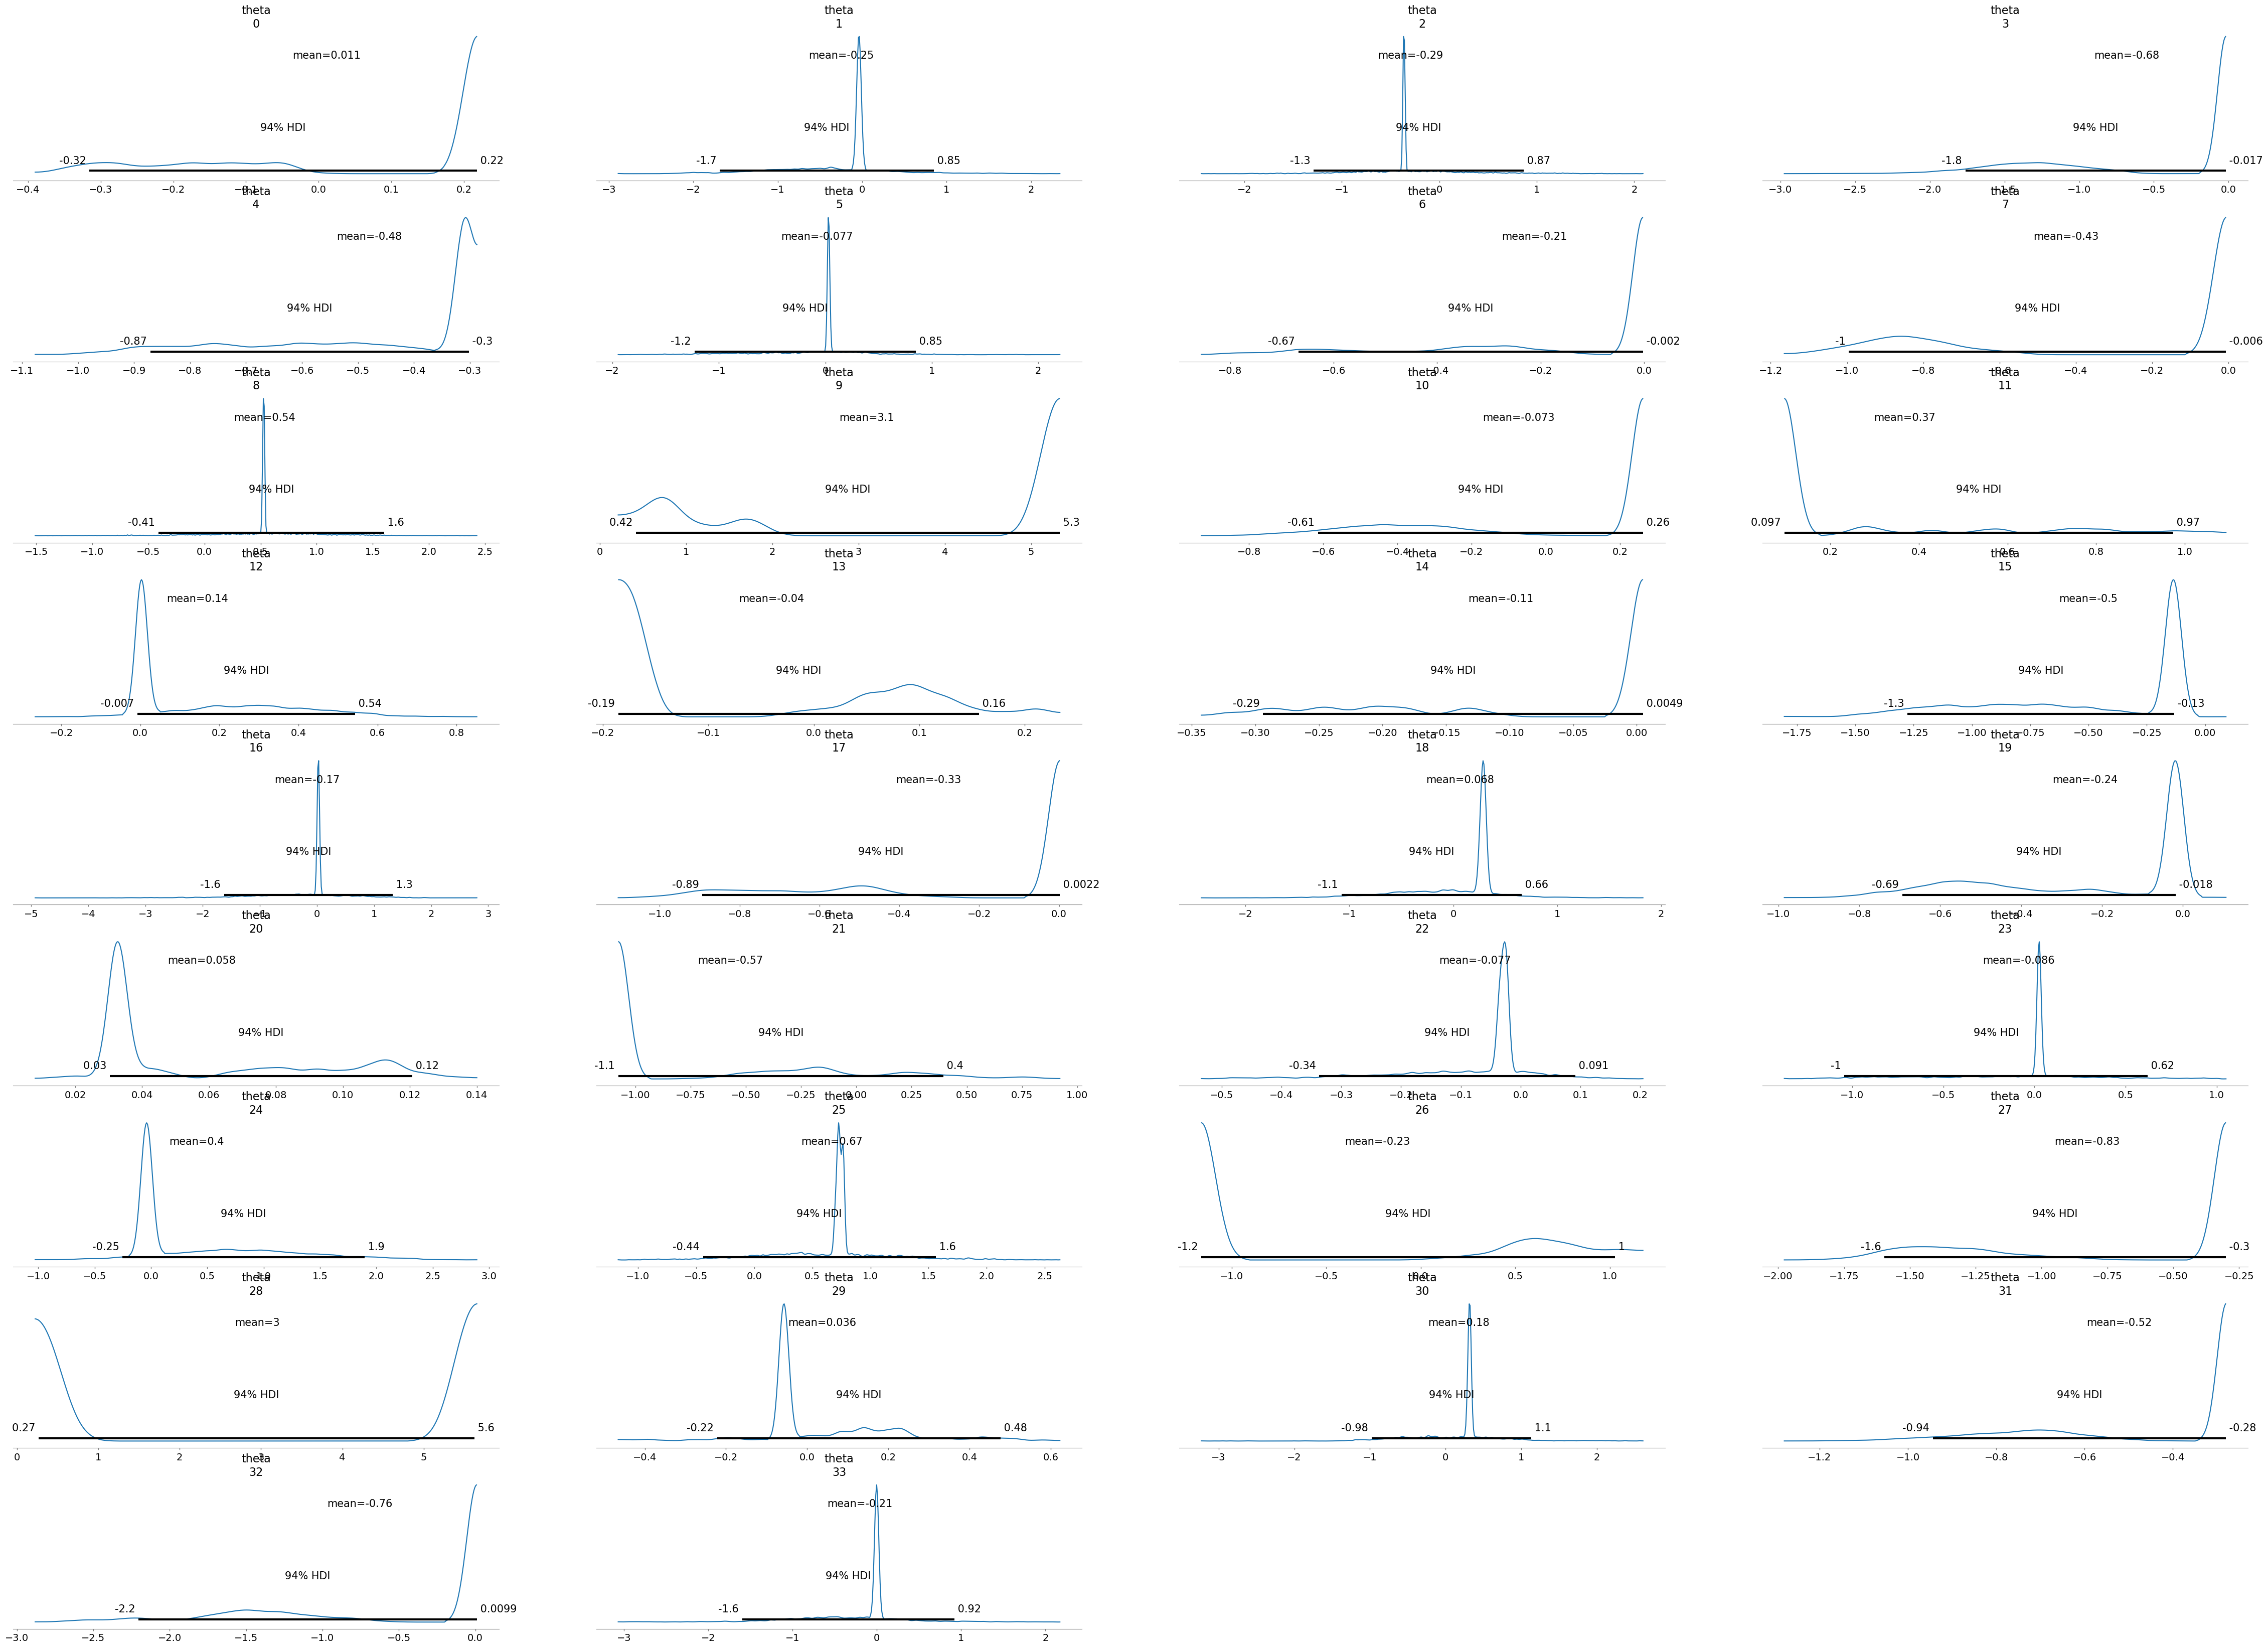

In [22]:
az.plot_posterior(burned_trace_spatial, var_names=["theta"])

Got error No model on context stack. trying to find log_likelihood in translation.


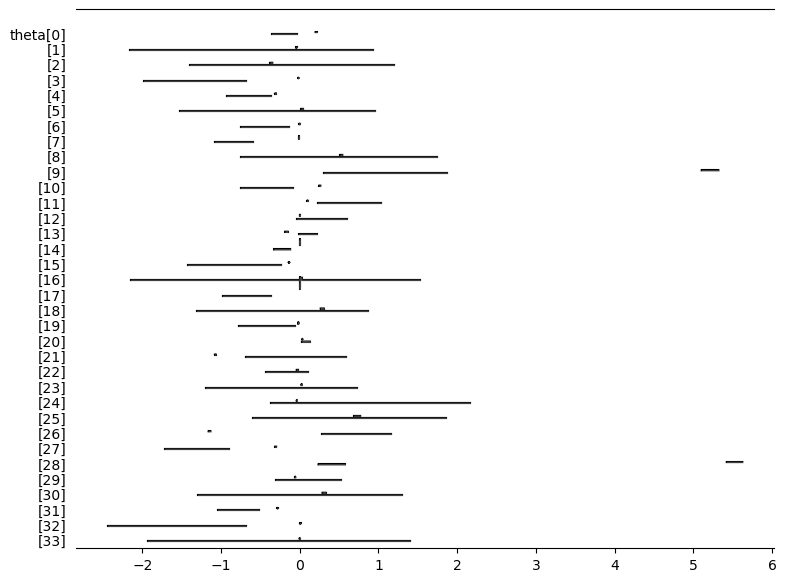

In [23]:
az.plot_forest(
    burned_trace_spatial,
    kind="ridgeplot",
    var_names=["theta"],
    combined=False,
    ridgeplot_overlap=3,
    ridgeplot_alpha=0.25,
    colors="white",
    figsize=(9, 7),
);

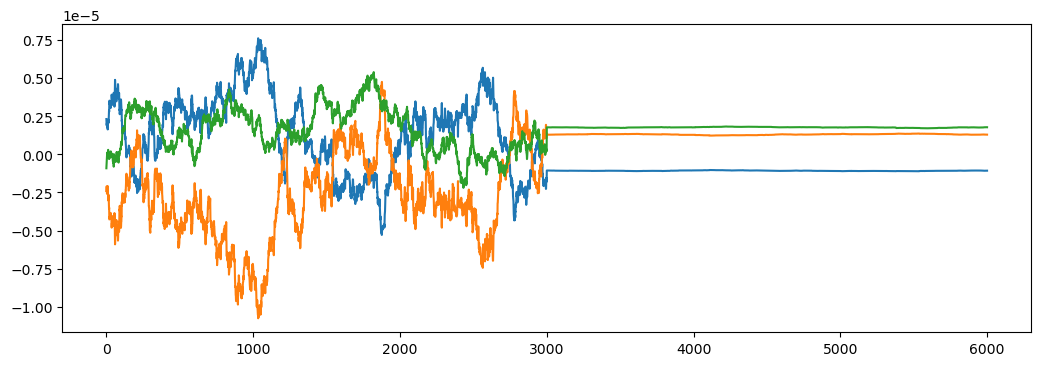

In [45]:
plt.plot(burned_trace_spatial["beta"])

In [329]:
theta_posterior = pd.DataFrame(burned_trace_spatial['theta']).T
# Calculate mean for each row
row_means = theta_posterior.mean(axis=1)

# Create new columns in the DataFrame for mean and z-score
theta_posterior['Mean'] = row_means
theta_posterior['Sig'] = [True,False,False,True,True,False,True,True,False,True,
                          True,True,True,True,True,True,False,True,False,True,
                          True,False,False,False,False,False,True,True,True,False,
                          False,True,True,False]

theta_posterior['GISJOIN'] = pd.DataFrame(pivot_df['GISJOIN'])
theta_posterior = theta_posterior[theta_posterior.columns[6000:]]
theta_posterior.loc[~theta_posterior['Sig'], 'Mean'] = np.nan
theta_posterior.to_csv('theta_posterior.csv')

### Model III: Bayesian Spatio-Temporal Model

In [68]:
#data
N = pivot_df.shape[0]
T = 24
X = np.array(pivot_df[['POP','WPOP','HOUSE']])
base_n = np.array(pivot_df['FREQUENCY_base'])
Y = np.array(pivot_df.iloc[:,1:25])
wmat = weight_matrix.astype('float')
#amat = weight_matrix.astype("int32")
D = np.diag(wmat.sum(axis=1))

In [69]:
# Number of hours in a day
num_hours = 24

# Initialize an empty adjacency matrix
adj_matrix = np.zeros((num_hours, num_hours), dtype=int)

# Populate the adjacency matrix
for i in range(num_hours):
    # Hour to the left
    left_hour = (i - 1) % num_hours
    adj_matrix[i, left_hour] = 1

    # Hour to the right
    right_hour = (i + 1) % num_hours
    adj_matrix[i, right_hour] = 1

# Print the adjacency matrix
tmat = adj_matrix.astype('float')
D_t = np.diag(tmat.sum(axis=1))

In [70]:
with pm.Model() as model3:
    # Vague prior on intercept
    alpha = pm.Normal('alpha', mu=0, sd=100)  #flat distribution
    # Vague prior on covariate effect
    beta = pm.Normal('beta', mu=0, sd=10, shape=X.shape[1])
    
    epsilon = pm.Normal('epsilon', mu=0, sd=1, shape=(X.shape[0],T)) 
        
    # Spatial clustering prior    
    # Priors for spatial random effects
    #theta_tau = pm.Gamma("theta_tau", alpha=2.0, beta=2.0)
    #theta_alpha = pm.Uniform("theta_alpha", lower=0, upper=1)
    #theta = pm.MvNormal("theta", mu=0, tau=theta_tau * (D - theta_alpha * wmat), shape=N)

    phi_tau = pm.Gamma("phi_tau", alpha=2.0, beta=2.0)
    phi_alpha = pm.Uniform("phi_alpha", lower=0, upper=1)
    phi = pm.MvNormal("phi", mu=0, tau=phi_tau * (D_t - phi_alpha * tmat), shape=T)

    # Mean model
    R = pm.Deterministic("R", alpha + pm.math.dot(X, beta))
    
    # Define the likelihood with random noise for each hour
    for i in range(T):
        obs = pm.Poisson(f'obs_{i}', mu= base_n * pm.math.exp(R + phi[i] + epsilon[:, i]), observed=Y[:, i])

    start = pm.find_MAP()

    # Sample from the posterior distribution
    #print(model2.test_point)
    
    trace_time = pm.sample(5000, tune=1000, start = start, cores=1, target_accept=0.85)
    burned_trace_time = trace_time[2000:]

/var/folders/_b/2fh86x4j0qj7kqwt0z4153jm0000gn/T/ipykernel_1189/241362672.py:31: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace_time = pm.sample(5000, tune=1000, start = start, cores=1, target_accept=0.85)
/Users/yaxuanzhang/anaconda3/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [phi, phi_alpha, phi_tau, epsilon, beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 17273 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/yaxuanzhang/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

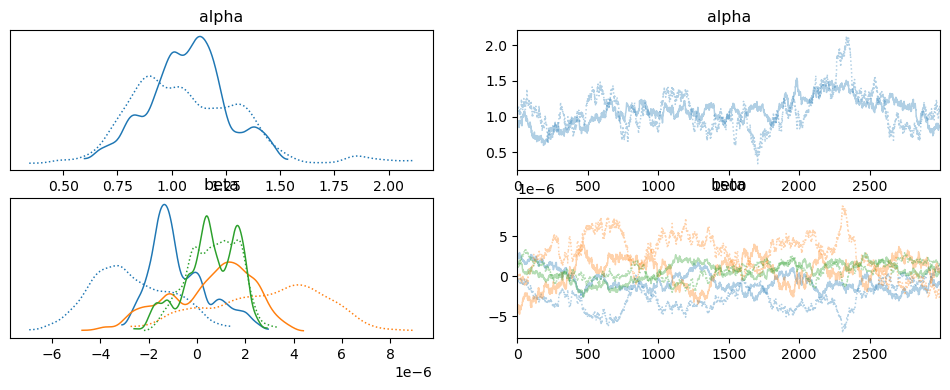

In [71]:
az.plot_trace(burned_trace_time, var_names=["alpha", "beta"])

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/yaxuanzhang/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>,
       <Axes: title={'center': 'beta\n2'}>], dtype=object)

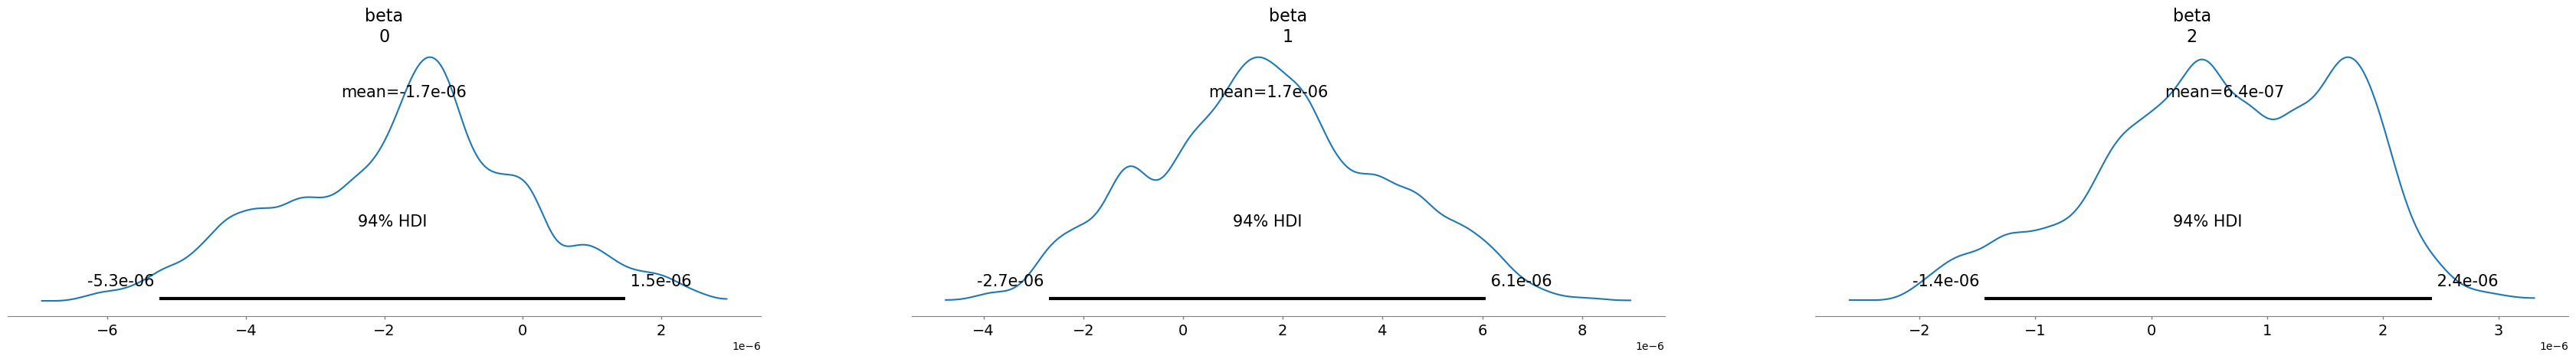

In [72]:
az.plot_posterior(burned_trace_time, var_names=["beta"])

Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'phi\n0'}>,
        <Axes: title={'center': 'phi\n1'}>,
        <Axes: title={'center': 'phi\n2'}>,
        <Axes: title={'center': 'phi\n3'}>],
       [<Axes: title={'center': 'phi\n4'}>,
        <Axes: title={'center': 'phi\n5'}>,
        <Axes: title={'center': 'phi\n6'}>,
        <Axes: title={'center': 'phi\n7'}>],
       [<Axes: title={'center': 'phi\n8'}>,
        <Axes: title={'center': 'phi\n9'}>,
        <Axes: title={'center': 'phi\n10'}>,
        <Axes: title={'center': 'phi\n11'}>],
       [<Axes: title={'center': 'phi\n12'}>,
        <Axes: title={'center': 'phi\n13'}>,
        <Axes: title={'center': 'phi\n14'}>,
        <Axes: title={'center': 'phi\n15'}>],
       [<Axes: title={'center': 'phi\n16'}>,
        <Axes: title={'center': 'phi\n17'}>,
        <Axes: title={'center': 'phi\n18'}>,
        <Axes: title={'center': 'phi\n19'}>],
       [<Axes: title={'center': 'phi\n20'}>,
        <Axes: title={'center': 'phi\n21'}>,
        <Axes: 

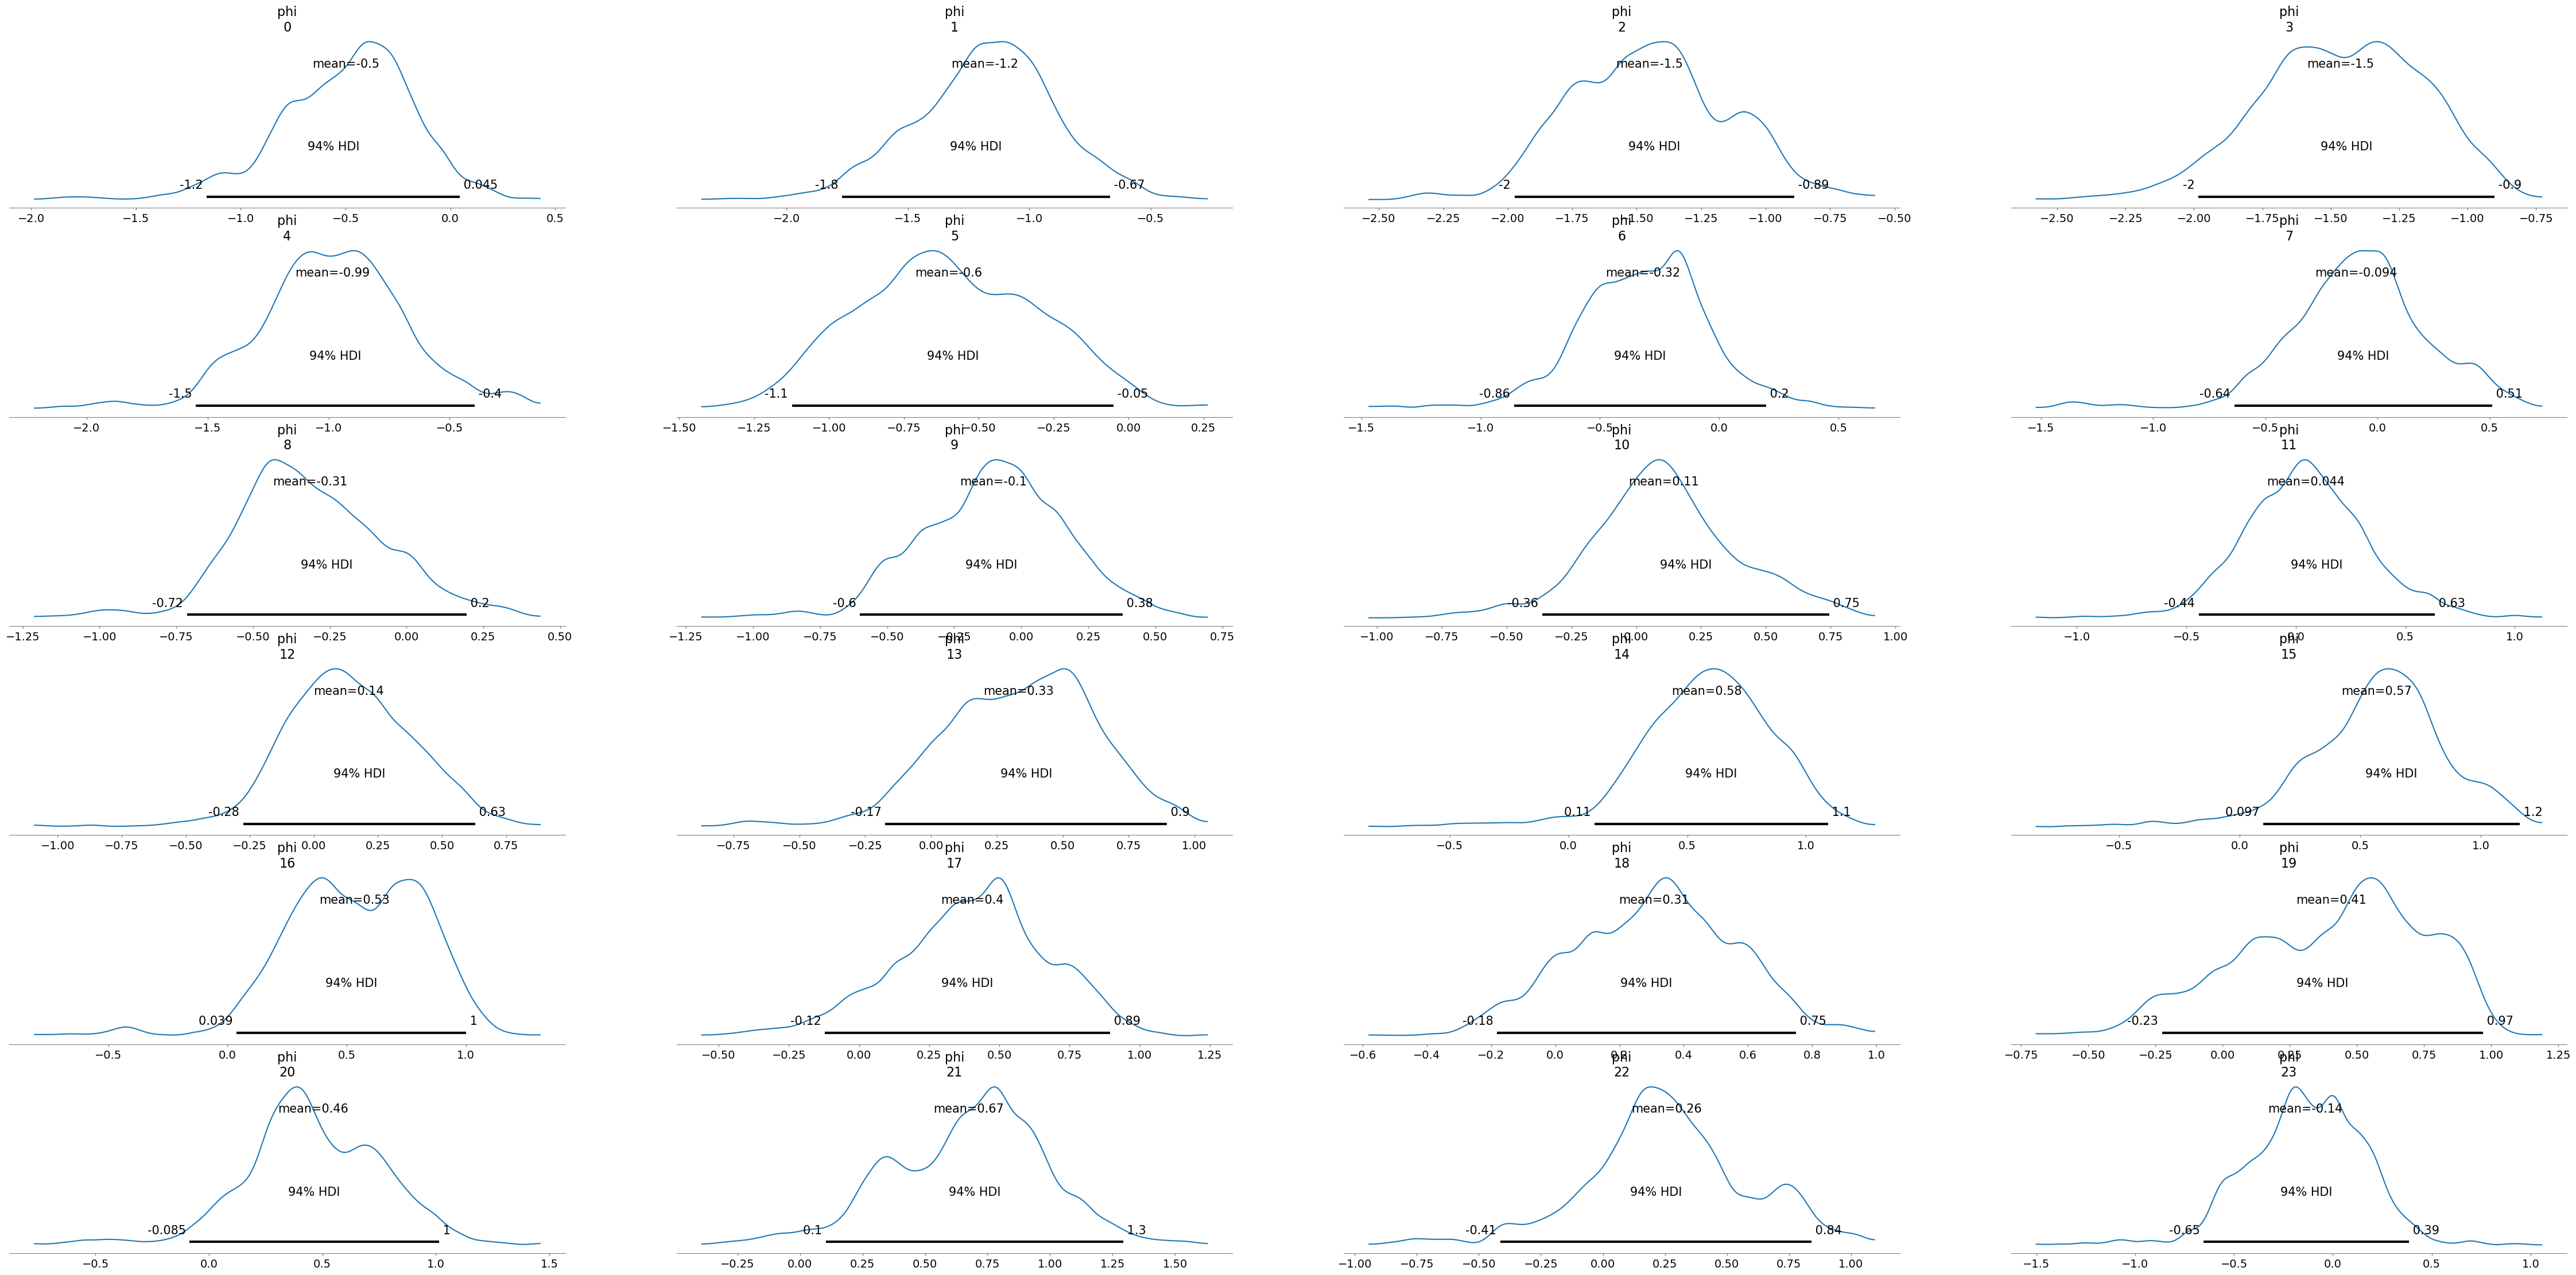

In [73]:
az.plot_posterior(burned_trace_time, var_names=["phi"])

Got error No model on context stack. trying to find log_likelihood in translation.


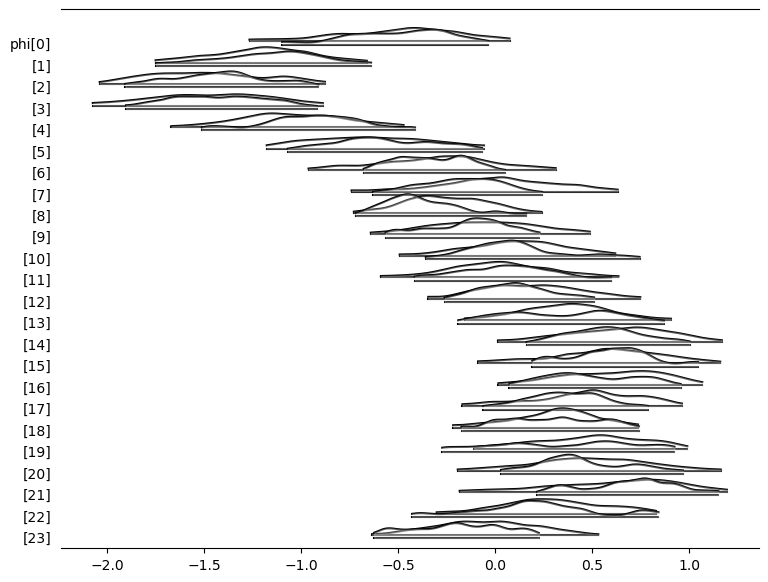

In [74]:
az.plot_forest(
    burned_trace_time,
    kind="ridgeplot",
    var_names=["phi"],
    combined=False,
    ridgeplot_overlap=3,
    ridgeplot_alpha=0.25,
    colors="white",
    figsize=(9, 7),
);

### Model IV: Bayesian Spatio-Temporal Model

In [39]:
#data
N = pivot_df.shape[0]
T = 24
X = np.array(pivot_df[['POP','WPOP','HOUSE']])
base_n = np.array(pivot_df['FREQUENCY_base'])
Y = np.array(pivot_df.iloc[:,1:25])
wmat = weight_matrix.astype('float')
#amat = weight_matrix.astype("int32")
D = np.diag(wmat.sum(axis=1))

In [40]:
with pm.Model() as model4:
    # Vague prior on intercept
    alpha = pm.Normal('alpha', mu=0, sd=100)  #flat distribution
    # Vague prior on covariate effect
    beta = pm.Normal('beta', mu=0, sd=10, shape=X.shape[1])
    
    epsilon = pm.Normal('epsilon', mu=0, sd=1, shape=(X.shape[0],T)) 
        
    # Spatial clustering prior    
    # Priors for spatial random effects
    theta_tau = pm.Gamma("theta_tau", alpha=2.0, beta=2.0)
    theta_alpha = pm.Uniform("theta_alpha", lower=0, upper=1)
    theta = pm.MvNormal("theta", mu=0, tau=theta_tau * (D - theta_alpha * wmat), shape=N)

    phi_tau = pm.Gamma("phi_tau", alpha=2.0, beta=2.0)
    phi_alpha = pm.Uniform("phi_alpha", lower=0, upper=1)
    phi = pm.MvNormal("phi", mu=0, tau=phi_tau * (D_t - phi_alpha * tmat), shape=T)

    # Mean model
    R = pm.Deterministic("R", alpha + pm.math.dot(X, beta)  + theta)
    
    # Define the likelihood with random noise for each hour
    for i in range(T):
        obs = pm.Poisson(f'obs_{i}', mu= base_n * pm.math.exp(R + phi[i] + epsilon[:, i]), observed=Y[:, i])

    start = pm.find_MAP()

    # Sample from the posterior distribution
    #print(model2.test_point)
    
    trace_sp = pm.sample(5000, tune=1000, start = start, cores=1, target_accept=0.85)
    burned_trace_sp = trace_sp[2000:]

/var/folders/_b/2fh86x4j0qj7kqwt0z4153jm0000gn/T/ipykernel_1189/30047426.py:31: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace_sp = pm.sample(5000, tune=1000, start = start, cores=1, target_accept=0.85)
/Users/yaxuanzhang/anaconda3/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [phi, phi_alpha, phi_tau, theta, theta_alpha, theta_tau, epsilon, beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 16147 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/yaxuanzhang/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

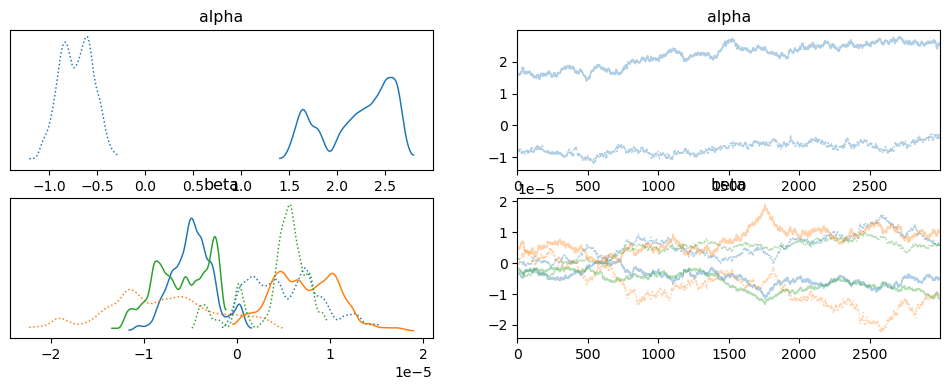

In [41]:
az.plot_trace(burned_trace_sp, var_names=["alpha", "beta"])

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/yaxuanzhang/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>,
       <Axes: title={'center': 'beta\n2'}>], dtype=object)

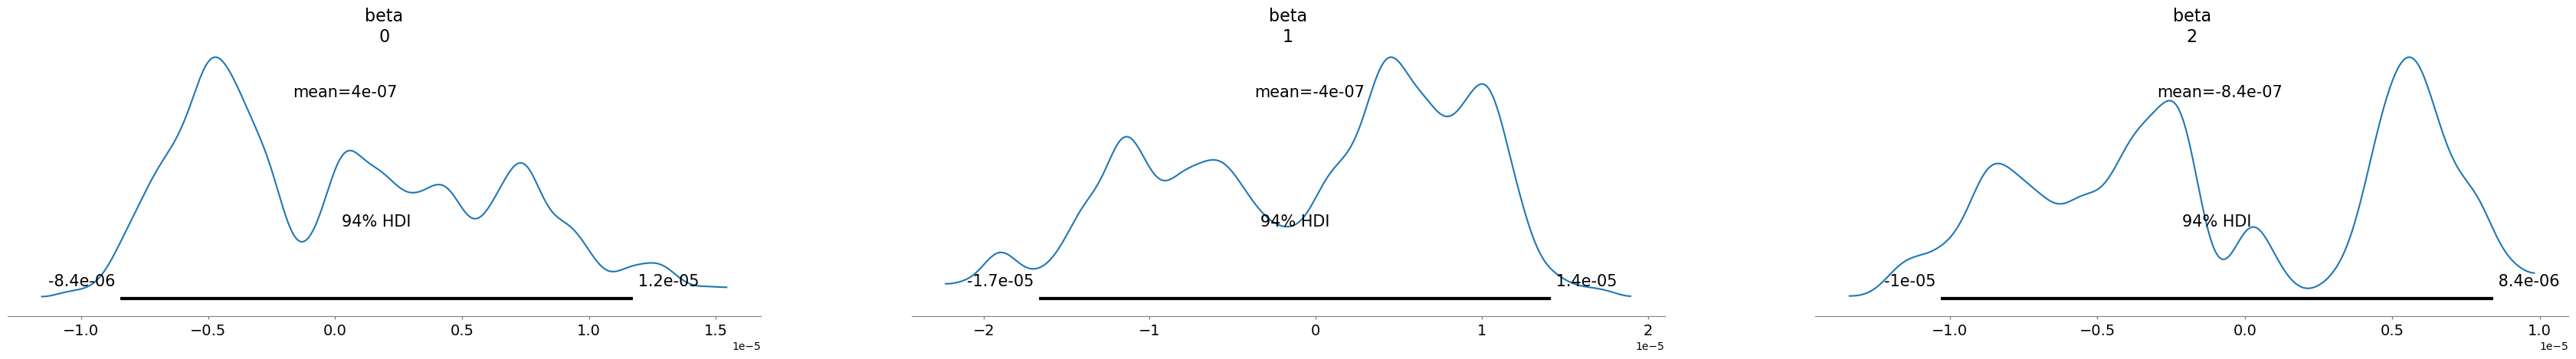

In [42]:
az.plot_posterior(burned_trace_sp, var_names=["beta"])

Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'phi\n0'}>,
        <Axes: title={'center': 'phi\n1'}>,
        <Axes: title={'center': 'phi\n2'}>,
        <Axes: title={'center': 'phi\n3'}>],
       [<Axes: title={'center': 'phi\n4'}>,
        <Axes: title={'center': 'phi\n5'}>,
        <Axes: title={'center': 'phi\n6'}>,
        <Axes: title={'center': 'phi\n7'}>],
       [<Axes: title={'center': 'phi\n8'}>,
        <Axes: title={'center': 'phi\n9'}>,
        <Axes: title={'center': 'phi\n10'}>,
        <Axes: title={'center': 'phi\n11'}>],
       [<Axes: title={'center': 'phi\n12'}>,
        <Axes: title={'center': 'phi\n13'}>,
        <Axes: title={'center': 'phi\n14'}>,
        <Axes: title={'center': 'phi\n15'}>],
       [<Axes: title={'center': 'phi\n16'}>,
        <Axes: title={'center': 'phi\n17'}>,
        <Axes: title={'center': 'phi\n18'}>,
        <Axes: title={'center': 'phi\n19'}>],
       [<Axes: title={'center': 'phi\n20'}>,
        <Axes: title={'center': 'phi\n21'}>,
        <Axes: 

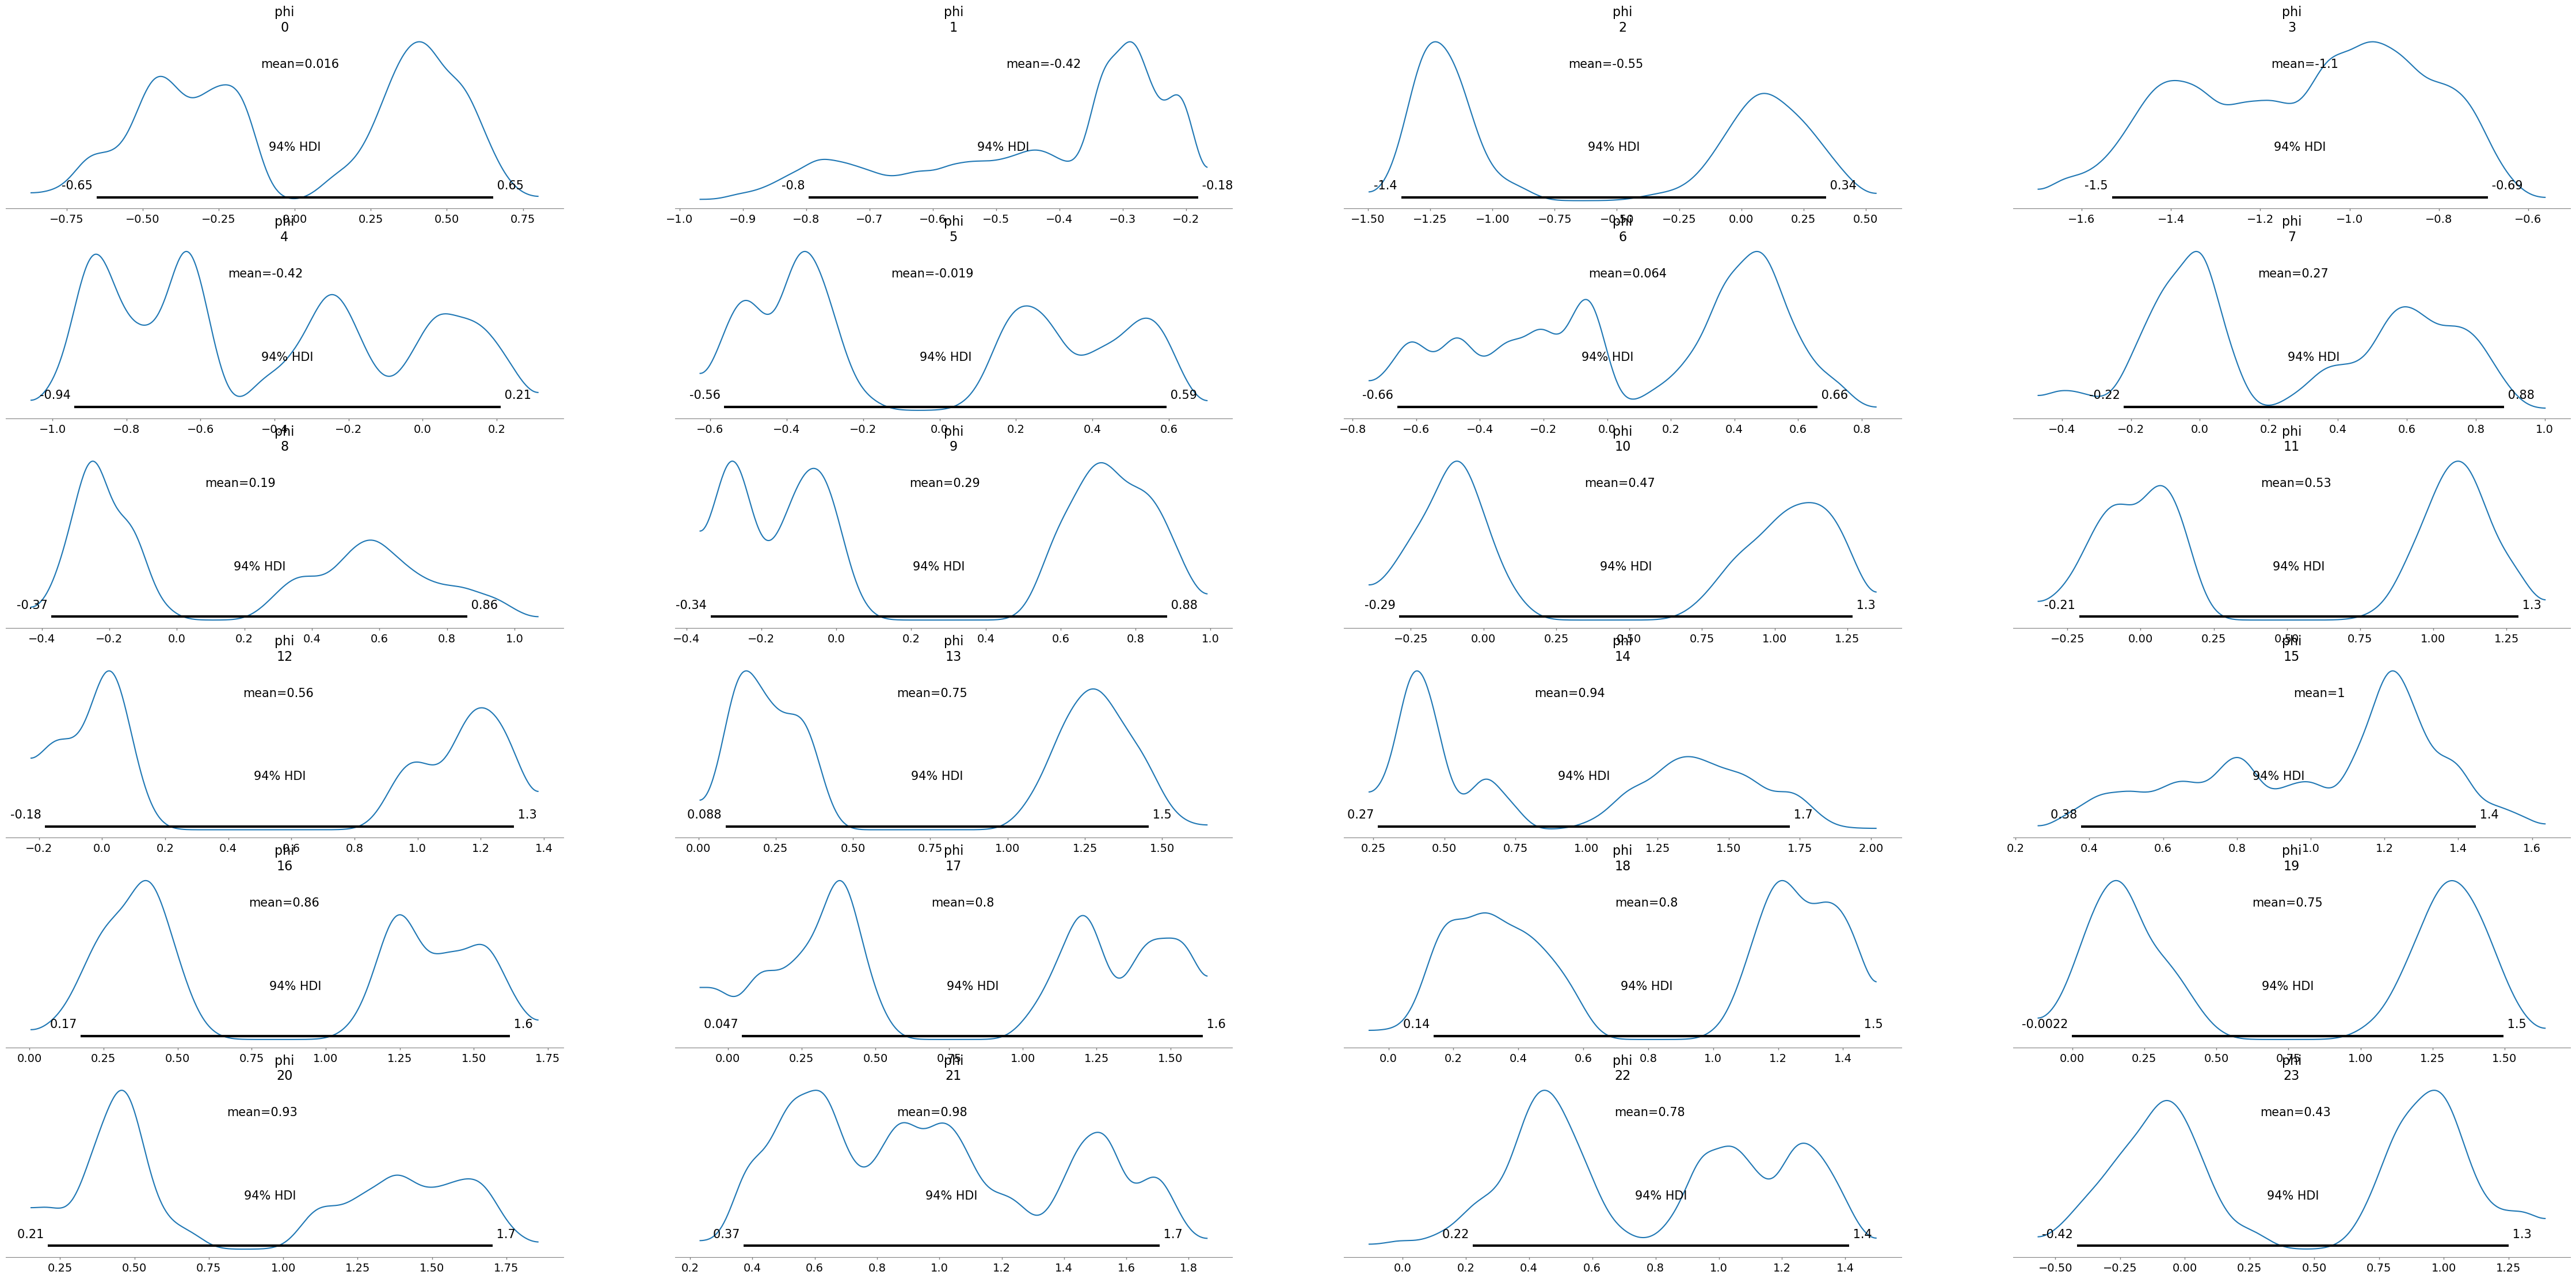

In [43]:
az.plot_posterior(burned_trace_sp, var_names=["phi"])

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/yaxuanzhang/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


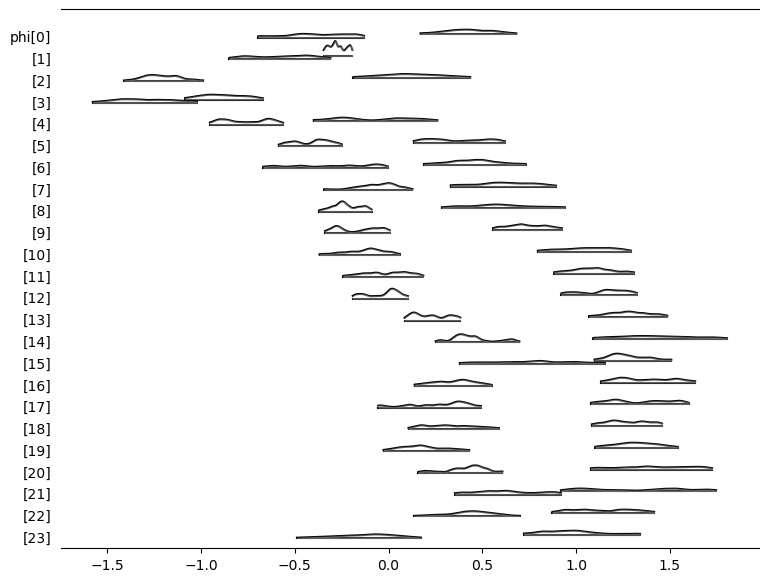

In [65]:
az.plot_forest(
    burned_trace_sp,
    kind="ridgeplot",
    var_names=["phi"],
    combined=False,
    #ridgeplot_overlap=3,
    ridgeplot_alpha=0.25,
    colors="white",
    figsize=(9, 7),
);

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/yaxuanzhang/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


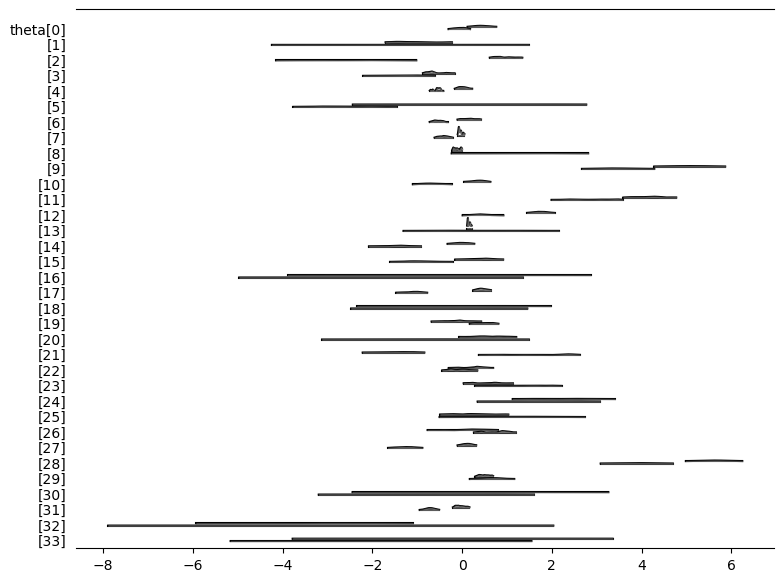

In [66]:
az.plot_forest(
    burned_trace_sp,
    kind="ridgeplot",
    var_names=["theta"],
    combined=False,
    #ridgeplot_overlap=3,
    ridgeplot_alpha=0.25,
    colors="white",
    figsize=(9, 7),
);

## Validation

In [230]:
pickup_data = pd.read_csv('PickUp_May_County_Count.csv')
selected_county = pd.read_csv('selected_county.csv')
acs_county = pd.read_csv('ACS_county.csv')

In [231]:
df = selected_county.loc[selected_county.index.repeat(24)].reset_index(drop=True)

# Create a new 'hour' column based on the repetition
df['Hour'] = df.groupby('GISJOIN').cumcount()

In [232]:
df = df.merge(pickup_data,how='left', on=['GISJOIN','Hour'])
df['FREQUENCY'].fillna(0, inplace=True)
df = df.drop(['OID__x', 'OID__y'], axis=1)
df = df.merge(acs_county, how='left', on='GISJOIN')

In [233]:
# get base number
df_base = df[df['Hour'].isin([2, 3, 4, 5])]
df_base = df_base.groupby('GISJOIN').agg({'FREQUENCY':'mean'})

In [234]:
df = df.merge(df_base, how='left', on='GISJOIN',suffixes=('', '_base'))
df.loc[df['FREQUENCY_base'] == 0, 'FREQUENCY_base'] = 0.001
df.head()

,NAMELSAD,GISJOIN,Hour,FREQUENCY,STATE,POP,WPLACE,WPOP,HOUSE,FREQUENCY_base
0,Middlesex County,G0900070,0,0.0,Connecticut,163368,87502.0,137404.0,76124,0.001
1,Middlesex County,G0900070,1,0.0,Connecticut,163368,87502.0,137404.0,76124,0.001
2,Middlesex County,G0900070,2,0.0,Connecticut,163368,87502.0,137404.0,76124,0.001
3,Middlesex County,G0900070,3,0.0,Connecticut,163368,87502.0,137404.0,76124,0.001
4,Middlesex County,G0900070,4,0.0,Connecticut,163368,87502.0,137404.0,76124,0.001


In [235]:
pivot_df = df.pivot(index='GISJOIN', columns='Hour', values='FREQUENCY')
pivot_df.reset_index(inplace=True)
pivot_df = pivot_df.merge(df[['GISJOIN','POP','WPOP','HOUSE','FREQUENCY_base']].drop_duplicates(), how='left', on='GISJOIN')
pivot_df.head()

,GISJOIN,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,POP,WPOP,HOUSE,FREQUENCY_base
0,G0900010,11.0,6.0,4.0,1.0,2.0,4.0,2.0,6.0,7.0,...,17.0,15.0,26.0,29.0,34.0,26.0,944348,754186.0,370999,2.750
1,G0900050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,183031,153270.0,88153,0.001
2,G0900070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,163368,137404.0,76124,0.001
3,G0900090,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,859339,705188.0,366266,0.001
4,G3400030,19.0,8.0,10.0,11.0,16.0,15.0,21.0,34.0,25.0,...,40.0,19.0,54.0,44.0,44.0,28.0,929999,755651.0,356654,13.000


In [274]:
# Format data
X = np.array(df[['POP','WPOP','HOUSE']])
new_base_n = np.array(df['FREQUENCY_base'])
Y = np.array(df['FREQUENCY'])

# Update the likelihood in the model with the new_base_n
with model1:
    #base_n = pm.Data('base_n', new_base_n)
    pm.set_data({'base_n': new_base_n})
    y_test = pm.sample_posterior_predictive(burned_trace,samples=5000)
    mad = np.mean(np.abs(Y - y_test['Y_obs'].mean(axis=0)))
    
    log_likelihood = np.sum(np.log(y_test['Y_obs'].mean(axis=0)))

    # Number of parameters in the model
    num_parameters = len(burned_trace.varnames)

    # Calculate AIC
    aic = -2 * log_likelihood + 2 * num_parameters

    print(f'Mean Absolute Deviation (MAD): {mad}')
    print(f'AIC: {aic}')

/Users/yaxuanzhang/anaconda3/lib/python3.10/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Mean Absolute Deviation (MAD): 109.85958455882356
AIC: 1185.944705788842


In [276]:
# Format data
#data
T = 24
X = np.array(pivot_df[['POP','WPOP','HOUSE']])
new_base_n = np.array(pivot_df['FREQUENCY_base'])
Y = np.array(pivot_df.iloc[:,1:25])
mad = np.array([])
log_likelihood = np.array([])

# Update the likelihood in the model with the new_base_n
with model2:
    #base_n = pm.Data('base_n', new_base_n)
    #D = pm.Data('D',D)
    #print(burned_trace_spatial.get_values(''))
    pm.set_data({'base_n': new_base_n})
    y_test = pm.sample_posterior_predictive(burned_trace_spatial,samples=5000)
    for i in range(T):
        mad = np.append(mad, np.mean(np.abs(Y[:, i] - y_test[f'obs_{i}'].mean(axis=0))))
        log_likelihood = np.append(log_likelihood,np.sum(np.log(y_test[f'obs_{i}'].mean(axis=0))))
    mad = np.mean(mad)
    log_likelihood = np.sum(log_likelihood)
    
    # Number of parameters in the model
    num_parameters = len(burned_trace_spatial.varnames)

    # Calculate AIC
    aic = -2 * log_likelihood + 2 * num_parameters
    
    print(f'Mean Absolute Deviation (MAD): {mad}')
    print(f'AIC: {aic}')

/Users/yaxuanzhang/anaconda3/lib/python3.10/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Mean Absolute Deviation (MAD): 110.29497352941178
AIC: 638.0067948090885


In [277]:
mad = np.array([])
log_likelihood = np.array([])

# Update the likelihood in the model with the new_base_n
with model3:
    #base_n = pm.Data('base_n', new_base_n)
    pm.set_data({'base_n': new_base_n})
    y_test = pm.sample_posterior_predictive(burned_trace_time,samples=5000)
    for i in range(T):
        mad = np.append(mad, np.mean(np.abs(Y[:, i] - y_test[f'obs_{i}'].mean(axis=0))))
        log_likelihood = np.append(log_likelihood,np.sum(np.log(y_test[f'obs_{i}'].mean(axis=0))))
    mad = np.mean(mad)
    log_likelihood = np.sum(log_likelihood)
    
    # Number of parameters in the model
    num_parameters = len(burned_trace_time.varnames)

    # Calculate AIC
    aic = -2 * log_likelihood + 2 * num_parameters
    
    print(f'Mean Absolute Deviation (MAD): {mad}')
    print(f'AIC: {aic}')

Mean Absolute Deviation (MAD): 109.8299330882353
AIC: 1218.373237569695


In [289]:
mad = np.array([])
log_likelihood = np.array([])

# Update the likelihood in the model with the new_base_n
with model4:
    #base_n = pm.Data('base_n', new_base_n)
    pm.set_data({'base_n': new_base_n})
    y_test = pm.sample_posterior_predictive(burned_trace_sp,samples=5000)
    for i in range(T):
        mad = np.append(mad, np.mean(np.abs(Y[:, i] - y_test[f'obs_{i}'].mean(axis=0))))
        log_likelihood = np.append(log_likelihood,np.nansum(np.log(y_test[f'obs_{i}'].mean(axis=0))))
    mad = np.mean(mad)
    log_likelihood = np.nansum(log_likelihood)
    
    # Number of parameters in the model
    num_parameters = len(burned_trace_sp.varnames)

    # Calculate AIC
    aic = -2 * log_likelihood + 2 * num_parameters
    
    print(f'Mean Absolute Deviation (MAD): {mad}')
    print(f'AIC: {aic}')

Mean Absolute Deviation (MAD): 109.82539975490197
AIC: 320.89452762984064
